In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from pyfrechet.metric_spaces import MetricData
import pyfrechet.metric_spaces.wasserstein_1d as W1d
from scipy.optimize import minimize
from scipy import stats

INFO: Using numpy backend


In [2]:
filenames = ['./data/frbny-sce-public-microdata-latest 2.csv',
             './data/FRBNY-SCE-Public-Microdata-Complete-13-16.csv',
             './data/FRBNY-SCE-Public-Microdata-Complete-17-19.csv']
df = pd.concat([pd.read_csv(filename, sep=';', skiprows=1, low_memory=False) for filename in filenames])

print("Average # responses per month: ", df.groupby('date')['userid'].count().mean())

sdf = df[['date', 'Q9_cent50']].copy()
sdf_all = df[['date', 'Q9_cent50']]
sdf_all = sdf_all[~sdf_all.isna().any(axis=1)]


Average # responses per month:  1293.3833333333334


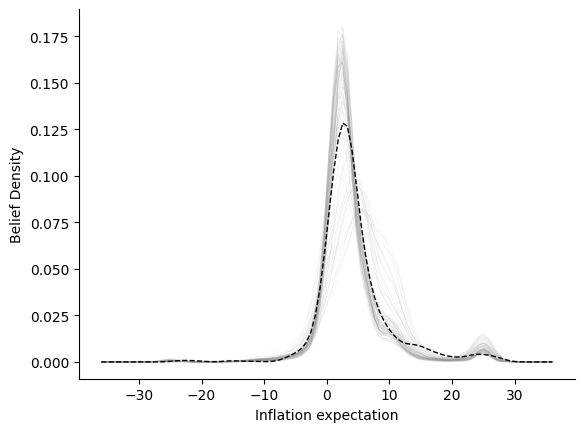

In [11]:
q_sup = np.linspace(0, 1, 100)
f_sup = np.linspace(-36, 36, 100)

med_qs = np.stack(sdf_all.groupby('date')['Q9_cent50'].apply(lambda s: np.quantile(s, q_sup)).values)
med_ds = np.stack(sdf_all.groupby('date')['Q9_cent50'].apply(lambda s: stats.gaussian_kde(s)(f_sup)))
med_cdf = np.stack(sdf_all.groupby('date')['Q9_cent50'].apply(lambda s: stats.ecdf(s).cdf.evaluate(f_sup)))

W = W1d.Wasserstein1D()
mu_hat = MetricData(W, med_qs).frechet_mean()

for i in range(med_ds.shape[0]):
    c = 0.6
    plt.plot(f_sup, med_ds[i,:], c=(c,c,c,0.15), linewidth=0.25)

plt.plot(
    f_sup,
    stats.gaussian_kde(np.interp(np.random.rand(1000), q_sup, mu_hat))(f_sup),
    '--',
    color='black',
    linewidth=1
)

fs = 18
plt.xlabel("Inflation expectation")#, fontsize=fs)
plt.ylabel("Belief Density")#, fontsize=fs)
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.savefig('./plots/belief_densities.pdf', bbox_inches='tight', transparent=True,)

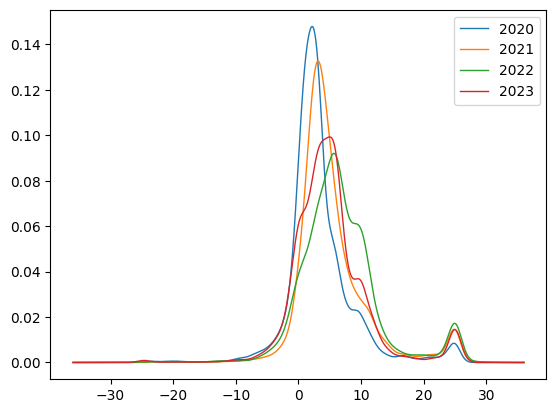

In [4]:
dates = pd.to_datetime(sdf_all.groupby('date').count().index, format='%Y%m')

_fms = np.zeros((11, med_qs.shape[1]))
fms = {
    2013: MetricData(W, med_qs[:7]).frechet_mean()
}
_fms[0,:] = stats.gaussian_kde(np.interp(np.random.rand(10000), q_sup, fms[2013]))(f_sup)
start = 7
for i in range(10):
    end = min(start+11, med_qs.shape[0]-1)
    fms[2014 + i] = MetricData(W, med_qs[start:end, :]).frechet_mean()
    start += 12
    _fms[i+1,:] = stats.gaussian_kde(np.interp(np.random.rand(10000), q_sup, fms[2014 + i]))(f_sup)


for year, mu_hat in fms.items():
    if year not in [2020, 2021, 2022, 2023]:
        continue
    plt.plot(
        f_sup,
        stats.gaussian_kde(np.interp(np.random.rand(10000), q_sup, mu_hat))(f_sup),
        # '--',
        label=year,
        linewidth=1
    )
plt.legend()


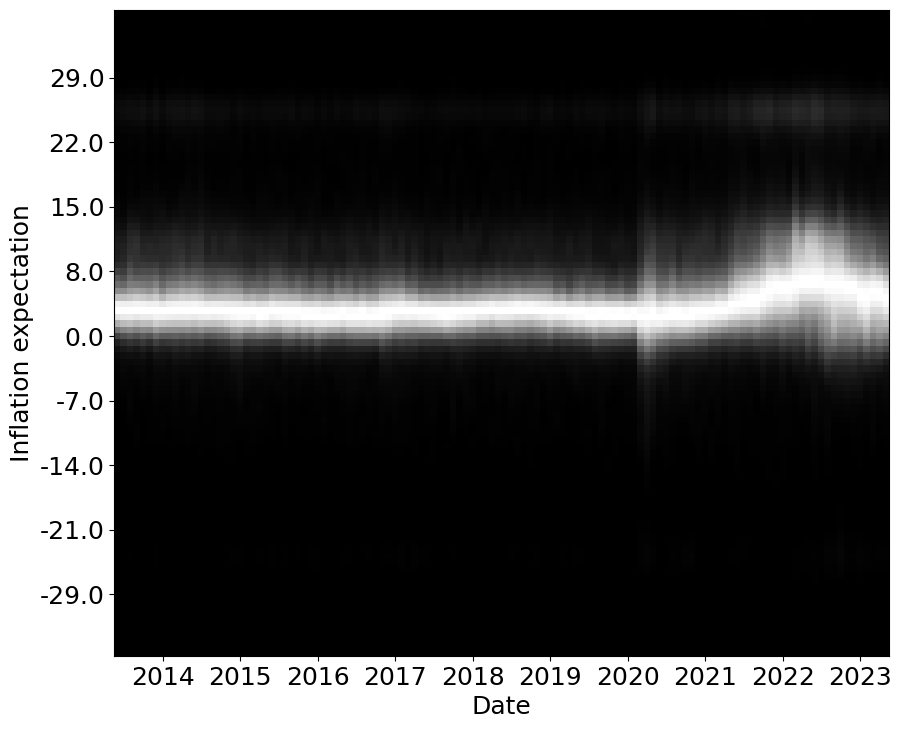

In [18]:
plt.figure(figsize=(10,10))
plt.imshow(np.flip(med_ds, axis=1).T / np.max(med_ds.T, axis=0), cmap='gray')
fs = 18
plt.yticks([10,20,30,40,50,60,70,80,90], np.round(f_sup[[10,20,30,40,50,60,70,80,90]])[::-1], fontsize=fs)
plt.xticks([7, 19, 31, 43, 55, 67, 79, 91, 103, 115], [2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023], fontsize=fs);
plt.xlabel('Date', fontsize=fs)
plt.ylabel('Inflation expectation', fontsize=fs);
plt.savefig('./plots/belief_img.pdf', bbox_inches='tight', transparent=True,)
# plt.ylim(25, 75);

In [139]:
def geodesic(x, theta, mu):
    return theta * x + (1-theta)*mu

def phi_hat(x, tol=None):
    mu_hat = MetricData(W, x).frechet_mean()
    T = x.shape[0]
    tol = 1e-5
    def L(phi): return np.array([ W._d(x[j+1,:], geodesic(x[j,:], phi, mu_hat))**2 for j in range(T-1) ]).mean()
    return minimize(L, np.random.rand(), method='Nelder-Mead', bounds=[(0,1)], options=dict(xatol=tol))['x'][0]

def bootstrap(x, stat, B):
    bootstrap = np.zeros(B)
    for b in tqdm(range(B)): bootstrap[b] = stat(np.random.permutation(x))
    return bootstrap

def Dt(x):
    return np.array([ W._d(x[j,:], x[j+1,:])**2 for j in range(x.shape[0]-1) ]).mean()

def predict(mu, phi, x):
    x_hat = np.zeros_like(x)
    x_hat[0,:] = mu
    for t in range(1, x.shape[0]):
        x_hat[t, :] = geodesic(x[t-1, :], phi, mu)
    return x_hat

B = 1000

x = med_qs
cdfs = med_cdf

W = W1d.Wasserstein1D()
mu_hat = MetricData(W, x).frechet_mean()

phi_hat_ = phi_hat(x)
Dt_ = Dt(x)

x_hat = predict(mu_hat, phi_hat_, x)

err_0 = np.array([ W._d(x[t,:], mu_hat)**2 for t in range(1, x.shape[0]) ])
err = np.array([ W._d(x[t,:], x_hat[t,:])**2 for t in range(1, x.shape[0]) ])

booted_dt = bootstrap(x, Dt, B)

print(f'Dt = {Dt_} (pval={(1 + (Dt_ > booted_dt).sum()) / (1 + booted_dt.shape[0])})')
print(f'phi = {phi_hat_}')
print(f'R^2 = {1 - err.mean() / err_0.mean():.2f}')

100%|██████████| 1000/1000 [00:01<00:00, 743.88it/s]

Dt = 0.7598991772275396 (pval=0.000999000999000999)
phi = 0.8502990829868811
R^2 = 0.72


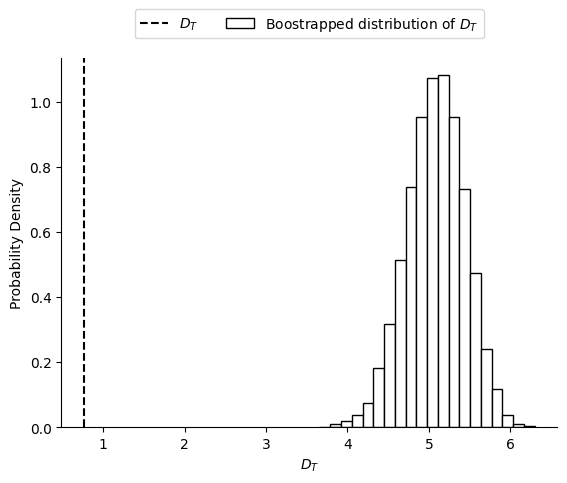

In [143]:
# booted_dt = bootstrap(x, Dt, 10000)

plt.axvline(Dt_, color='black', linestyle='dashed', label=r'$D_T$')
plt.hist(booted_dt, color='white', edgecolor='black', density=True, bins=20, label=r'Boostrapped distribution of $D_T$')
plt.xlabel(r'$D_T$')
plt.ylabel('Probability Density')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=2)

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.savefig('./plots/bootstrap_dt.pdf', bbox_inches='tight', transparent=True,)

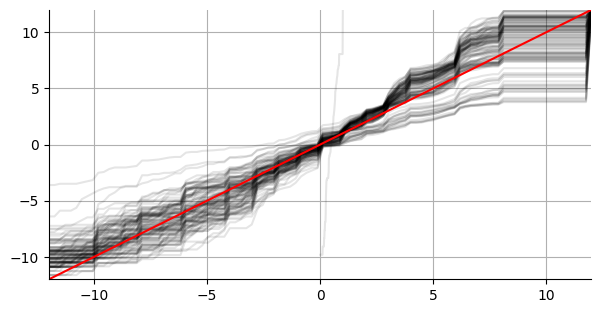

In [10]:
fig = plt.figure(figsize=(7,3.5))
plt.plot(q_sup, np.interp(cdfs[1,:], q_sup, x_hat[1,:]), color='black', alpha=0.1, label='Residual Maps')
for i in range(1,x.shape[0]):
    res = np.interp(cdfs[i,:], q_sup, mu_hat)
    plt.plot(f_sup, res, color='black', alpha=0.1)
plt.plot(f_sup, f_sup, color='red', label='Identity Map')
plt.xlim(-12,12)
plt.ylim(-12,12)
ax = plt.gca()
ax.grid('on')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.savefig('./plots/residuals_null.pdf', bbox_inches='tight', transparent=True,)

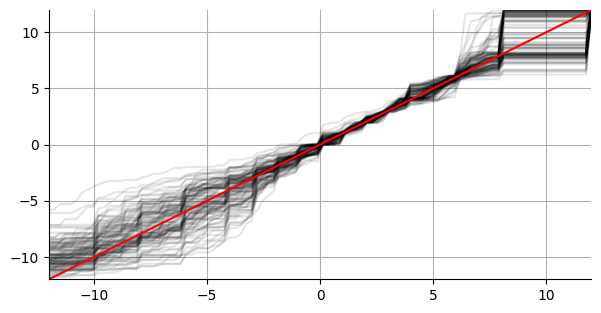

In [11]:
fig = plt.figure(figsize=(7,3.5))
plt.plot(f_sup, np.interp(cdfs[1,:], q_sup, x_hat[1,:]), color='black', alpha=0.1, label='Residual Maps')

for i in range(1,x.shape[0]):
    res = np.interp(cdfs[i,:], q_sup, x_hat[i,:])
    plt.plot(f_sup, res, color='black', alpha=0.1)
plt.plot(f_sup, f_sup, color='red', label='Identity Map')
plt.xlim(-12,12)
plt.ylim(-12,12)
ax = plt.gca()
ax.grid('on')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.savefig('./plots/residuals_model.pdf', bbox_inches='tight', transparent=True,)

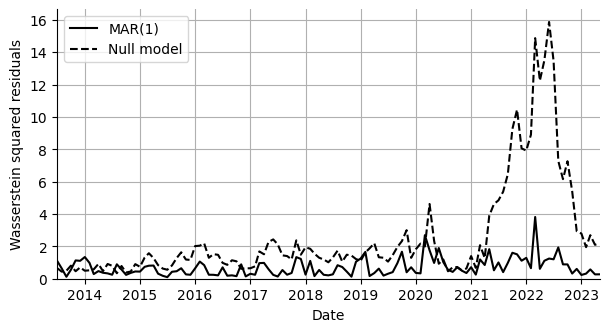

In [168]:
fig = plt.figure(figsize=(7,3.5))

dates = pd.to_datetime(sdf_all.groupby('date').count().index, format='%Y%m')[1:]

plt.plot(dates, err, label='MAR(1)', color='black')
plt.plot(dates, err_0, label='Null model', color='black', linestyle='dashed')

# plt.plot(np.arange(err_0.shape[0]), err_0, label='Null model')
# plt.plot(np.arange(err.shape[0]), err, label='MAR(1)')

# plt.scatter(np.arange(err_0.shape[0]), err_0, label='Null model')
# plt.scatter(np.arange(err.shape[0]), err, label='MAR(1)')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Wasserstein squared residuals')
plt.ylim(0)
plt.xlim(dates[0], dates[-1])
# plt.xlim(0,x.shape[0])
# plt.xticks(pd.to_datetime(sdf_all.groupby('date').count().index, format='%Y%m'))

ax = plt.gca()
ax.grid('on')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.savefig('./plots/data_residuals_time.pdf', bbox_inches='tight', transparent=True,)

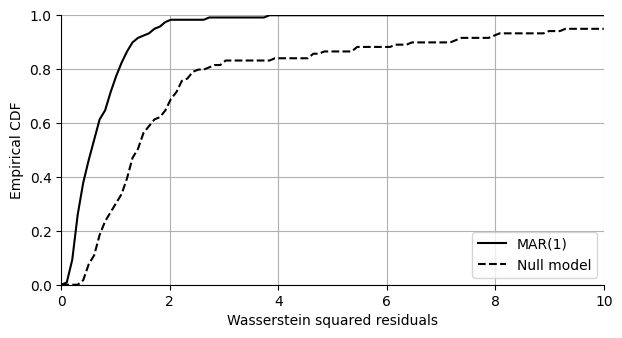

In [169]:
fig = plt.figure(figsize=(7,3.5))
dom = np.linspace(0,10,100)

plt.plot(dom, stats.ecdf(err).cdf.evaluate(dom), label='MAR(1)', color='black')
plt.plot(dom, stats.ecdf(err_0).cdf.evaluate(dom), label='Null model', color='black', linestyle='dashed')

plt.legend()
plt.xlabel('Wasserstein squared residuals')
plt.ylabel('Empirical CDF')
plt.ylim(0,1)
plt.xlim(0,10)
ax = plt.gca()
ax.grid('on')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.savefig('./plots/data_residuals_ecdf.pdf', bbox_inches='tight', transparent=True,)

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

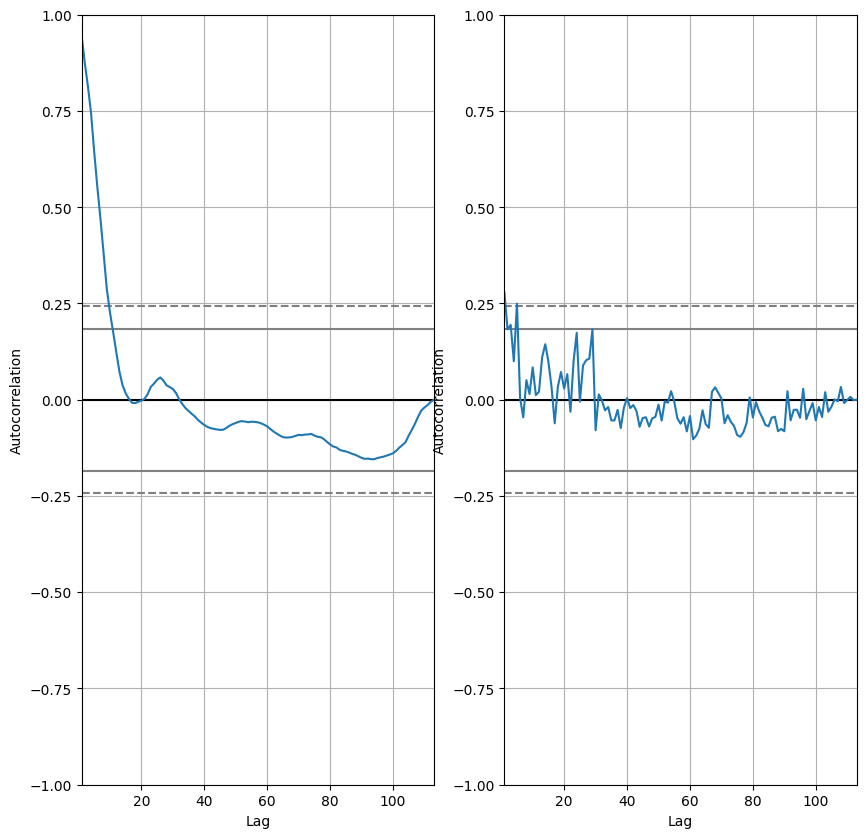

In [46]:
plt.figure(figsize=(10,10))

plt.subplot(1,2,1)
pd.plotting.autocorrelation_plot(err_0)  
plt.subplot(1,2,2)
pd.plotting.autocorrelation_plot(err)  